In [6]:
from datetime import datetime
import glob
import aisisax.object_detection.lsa_interface as aisax_object_detection
import aisisax.llm.openai_connector as aisax_openai
import logging as l

import pandas as pd
import json

from IPython.display import Image,display

Environment Variablen laden
---------------------------

.env wird geladen.

In [7]:
from dotenv import load_dotenv

load_dotenv()


True

In [8]:
    # Move the DataFrame creation and processing logic into this function
    df = pd.DataFrame(columns=['filename', 'timestamp', 'ppn', 'page_number', 
                             'arabic_numeral_present', 'arabic_numeral_int', 
                             'illustration_present', 'illustration_position', 
                             'illustration_with_text_below', 'tibetian_page_number', 
                             'chinese_char_present', 'chinese_page_number', 'box_present'])

Image laden und anzeigen
------------------------

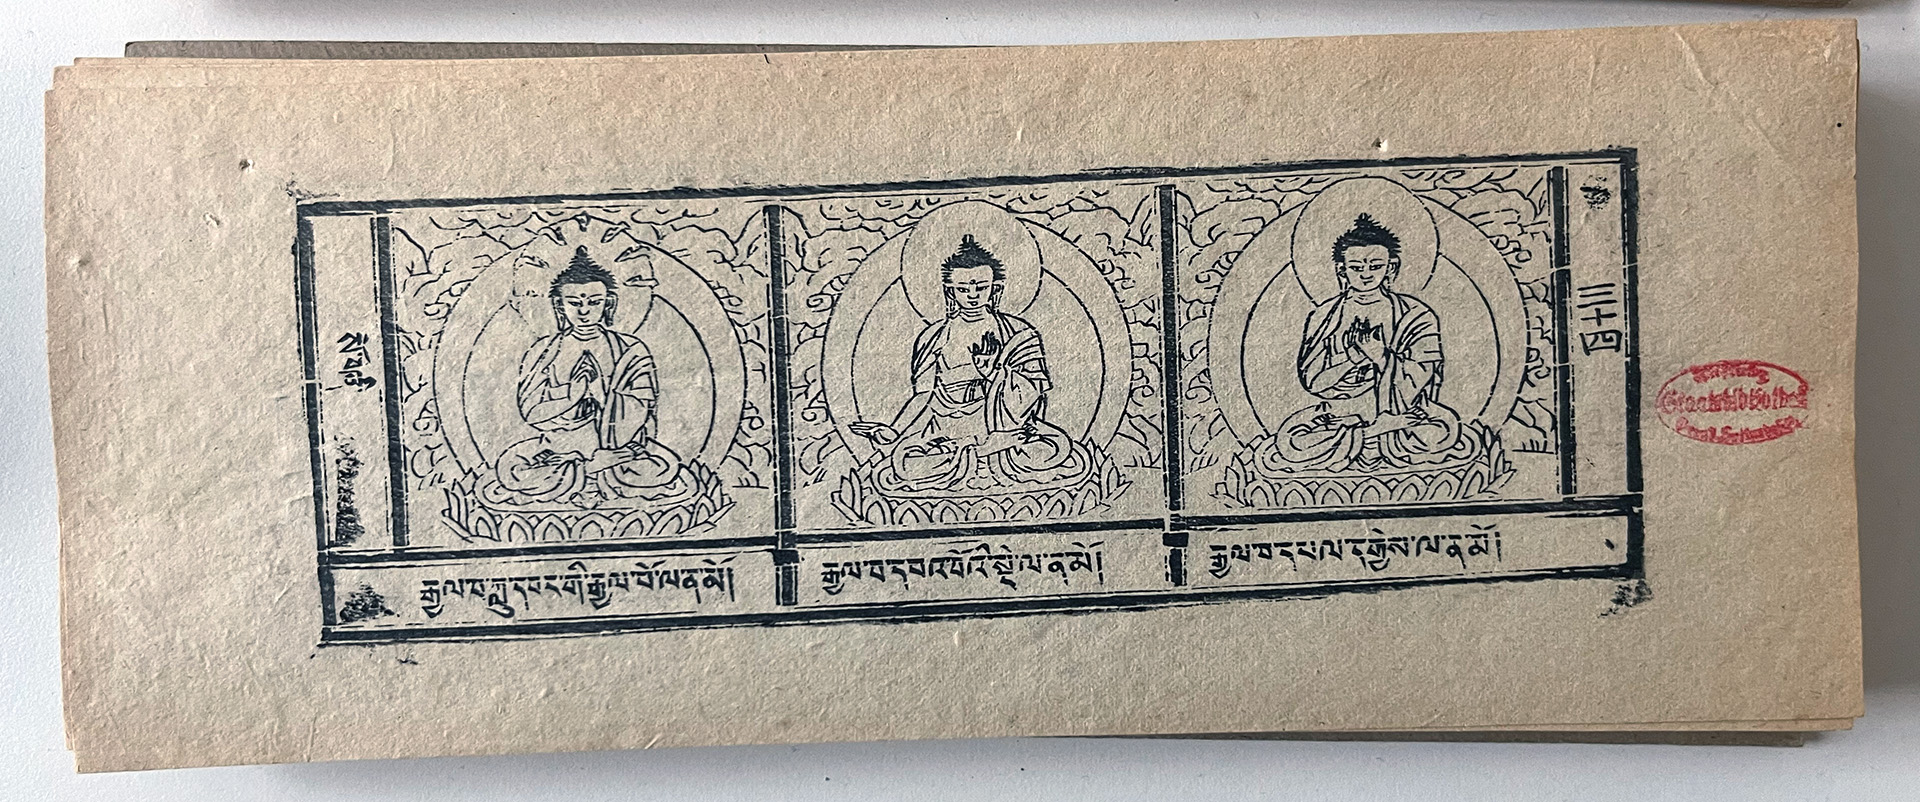

In [67]:
    input_dir = 'assets'
    pImage = 'IMG_5086.jpg'
    display( Image(filename=input_dir +'/' + pImage) )

GPT-4o das Bild analysieren lassen
----------------------------------

In [68]:
        result=aisax_openai.generate_multimodal_answer("""You are an expert for interpreting Tibetan manuscripts. 
                                                   Attached you will find an image of a tibetan manuscript. 
                                                   Answer the following questions and respond as a pure JSON object the following format:
                                                   {
                                                   "chinese": {
                                                       "present": "bool (Is there at least one Chinese character or number on the image?)",
                                                       "page_number": "bool (Does the image contain at least one chinese character or number, that is vertical oriented and is on the right side of the image outside of the tibet?)",
                                                       "bbox": [ min_x, min_y, max_x, max_y ], /* Bounding box coordinates. If the image does not contain chinese characters say [ null, null, null, null ]. If it does contain chinese characters report the minimum x, minimum y, maximum x and maximum y pixel coordinate in the image or null if not known. */

                                                   },
                                                   "arabic": {
                                                       "numeral_present": "bool (Does the image contain an Arabic numeral?)",
                                                       "numeral_int": "Integer (If there is an Arabic numeral, which one?)",
                                                       "bbox": [ min_x, min_y, max_x, max_y ], /* Bounding box coordinates. If the image does not contain arabic numerals say [ null, null, null, null ]. If it does contain arabic numerals report the minimum x, minimum y, maximum x and maximum y pixel coordinate in the image or null if not known. */

                                                   },
                                                   "illustration": {
                                                       "present": "bool (Does the image contain an illustration?)",   
                                                       "position": "string (If the image contains not an illustration say " ", else return the postion and say depending of the ilustrated area either left say 'l', either right say 'r', either center say 'c', either left AND right say 'lr', either left AND centered AND right say 'lcr', either left AND centered say 'lc', either right AND centered say 'rc'",
                                                       "bbox": [ min_x, min_y, max_x, max_y ], /* Bounding box coordinates. If the image contains not an illustration say [ null, null, null, null ]. If it does contain an illustration report the minimum x, minimum y, maximum x and maximum y pixel coordinate in the image or null if not known. */
                                                       "with_text_below": "bool (Does the image contain an illustration with a caption?)",
                                                   },
                                                   "tibetian": {
                                                       "page_number": "bool (Does the image contain a tibetian characters, that are vertical oriented and left aligned. If so say 'true', 'false' otherwise.)",
                                                       "bbox": [ min_x, min_y, max_x, max_y ], /* Bounding box coordinates. If the image contains not tibetian characters say [ null, null, null, null ]. If it does contain tibetan characters report the minimum x, minimum y, maximum x and maximum y pixel coordinate in the image or null if not known. */
                                                   },
                                                   "box_present": "char (Is there a frame around the Text? Say 'N' for none, 'R' for Red and "B" for black!)",
                                                   }
                                                   """, image_path=input_dir + '/' + pImage, temperature=0.5)


In [69]:
json_result = json.loads(result[7:-3])
print(json.dumps(json_result, indent=4))

{
    "chinese": {
        "present": true,
        "page_number": true,
        "bbox": [
            1230,
            150,
            1270,
            300
        ]
    },
    "arabic": {
        "numeral_present": false,
        "numeral_int": null,
        "bbox": [
            null,
            null,
            null,
            null
        ]
    },
    "illustration": {
        "present": true,
        "position": "lcr",
        "bbox": [
            50,
            100,
            1750,
            700
        ],
        "with_text_below": true
    },
    "tibetian": {
        "page_number": true,
        "bbox": [
            50,
            100,
            100,
            700
        ]
    },
    "box_present": "B"
}


Bounding boxes grafisch darstellen und abspeichern mit Hilfe von OpenCV und matplotlib
----------------------------------------------------------------------

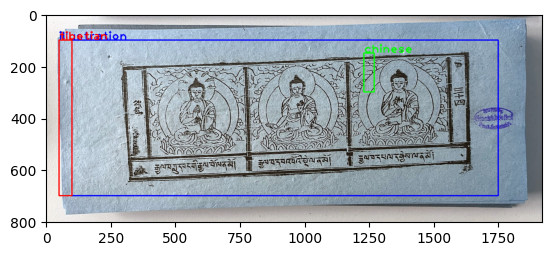

In [70]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt

output_dir = 'output'

img = cv2.imread(input_dir + '/' + pImage)
cv2.rectangle(img, 
              (json_result["illustration"]["bbox"][0], json_result["illustration"]["bbox"][1]), 
              (json_result["illustration"]["bbox"][2], json_result["illustration"]["bbox"][3]),
              (0, 0, 255),
              3)
cv2.putText(img,
            "illustration",
            (json_result["illustration"]["bbox"][0], json_result["illustration"]["bbox"][1]), 
            cv2.FONT_HERSHEY_PLAIN,
            3,
            (0, 0, 255),
            3)
cv2.rectangle(img, 
              (json_result["chinese"]["bbox"][0], json_result["chinese"]["bbox"][1]), 
              (json_result["chinese"]["bbox"][2], json_result["chinese"]["bbox"][3]),
              (0, 255, 0),
              3)
cv2.putText(img,
            "chinese",
            (json_result["chinese"]["bbox"][0], json_result["chinese"]["bbox"][1]), 
            cv2.FONT_HERSHEY_PLAIN,
            3,
            (0, 255, 0),
            3)
cv2.rectangle(img, 
              (json_result["tibetian"]["bbox"][0], json_result["tibetian"]["bbox"][1]), 
              (json_result["tibetian"]["bbox"][2], json_result["tibetian"]["bbox"][3]),
              (255, 0, 0),
              3)
cv2.putText(img,
            "tibetian",
            (json_result["tibetian"]["bbox"][0], json_result["tibetian"]["bbox"][1]), 
            cv2.FONT_HERSHEY_PLAIN,
            3,
            (255, 0, 0),
            3)
# Bild speichern
cv2.imwrite(output_dir + '/' + pImage, img)
# Bild anzeigen
plt.imshow(img)
plt.show()


Tabelle anzeigen
----------------

(Das braucht noch mehr Arbeit.)

In [77]:
        # extract ppl and page number from the filename
        page_number = pImage.split("_")[0]

        # Strip "assets/" from the beginning of the filename
        json_result["filename"] = pImage.replace("assets/", "")
        json_result["timestamp"] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        json_result["ppn"] = pImage
        json_result["page_number"] = page_number

        # Append the result to the dataframe
        df = pd.concat([df, pd.DataFrame([json_result])], ignore_index=True)

        # Define a formatter function for the 'filename' column to include images and links
        def image_formatter(filename):
            return f'<a href="assets/{filename}"><img src="assets/{filename}" alt="{filename}""></a>'

        # Apply the formatter to the 'filename' column
        df['filename'] = df['filename'].apply(image_formatter)

        # Optionally, rename the 'filename' column to 'Image' for clarity in the HTML table
        df.rename(columns={'filename': 'Image'}, inplace=True)

        # Move the 'timestamp' column to the last position
        df['timestamp'] = df.pop('timestamp')

        display(df)

,Image,ppn,page_number,arabic_numeral_present,arabic_numeral_int,illustration_present,illustration_position,illustration_with_text_below,tibetian_page_number,chinese_char_present,chinese_page_number,box_present,chinese,arabic,illustration,tibetian,Image,timestamp
0,"<a href=""assets/IMG_5086.jpg""><img src=""assets...",IMG_5086.jpg,IMG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,"{'present': True, 'page_number': True, 'bbox':...","{'numeral_present': False, 'numeral_int': None...","{'present': True, 'position': 'lcr', 'bbox': [...","{'page_number': True, 'bbox': [50, 100, 100, 7...","<a href=""assets/nan""><img src=""assets/nan"" alt...",2024-11-24 15:17:42
1,NaN,IMG_5086.jpg,IMG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,"{'present': True, 'page_number': True, 'bbox':...","{'numeral_present': False, 'numeral_int': None...","{'present': True, 'position': 'lcr', 'bbox': [...","{'page_number': True, 'bbox': [50, 100, 100, 7...","<a href=""assets/IMG_5086.jpg""><img src=""assets...",2024-11-24 15:24:31
